<a href="https://colab.research.google.com/github/ah20776/CE888/blob/main/Lab_8/Transfer_learning_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ah20776/CE888.git

Cloning into 'CE888'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 230 (delta 83), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (230/230), 21.16 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [2]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/CE888/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [4]:
import os
data_dir_list = os.listdir('/content/data')
path, dirs, files = next(os.walk("/content/data"))
file_count = len(files)
print(file_count)

0


In [5]:
# Make new base directory
original_dataset_dir = '/content/data'
base_dir = '/content/lab8'
os.mkdir(base_dir)

In [6]:
data_dir_list = os.listdir('/content/data')
print(data_dir_list)
path, dirs, files = next(os.walk("/content/data"))

['Humans', 'dogs', 'horses', 'cats']


In [7]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [8]:
categories = {}
for i in dirs:
  categories[i] = dirs.index(i)

print(categories)

{'Humans': 0, 'dogs': 1, 'horses': 2, 'cats': 3}


In [9]:
import cv2
import numpy as np
from random import shuffle
from tensorflow.keras.utils import to_categorical


IMG_SIZE = 224
LR = 1e-4

In [10]:

from google.colab.patches import cv2_imshow

images= []       
y = []     
for dir in dirs:
    for dirname, _, filenames in os.walk(path+'/'+dir):
        for filename in filenames:
            file_path = str(path+'/'+dir+'/'+filename)
            image = cv2.resize(cv2.imread(file_path), (224, 224))
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            images.append(np.array(image))
            y.append(categories[str(dir)])
images = np.array(images)
y =np.array(to_categorical(y,num_classes=4))

In [11]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [12]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [13]:
from sklearn.model_selection import train_test_split
traval_x, test_x, traval_y, test_y = train_test_split(images, y,
                                                    stratify=y, 
                                                    test_size=0.3)

In [14]:
train_x,validation_x,train_y,validation_y = train_test_split(traval_x,traval_y,
                                                    stratify=traval_y, 
                                                    test_size=0.3)

In [15]:
## MobileNet
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [16]:
model = MobileNet(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    classifier_activation="softmax")
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [17]:
last_layer = model.get_layer('predictions').output
out = Dense(4, activation='softmax', name='output')(last_layer) 
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [20]:
history = model.fit(train_x, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(validation_x, validation_y),
                               callbacks=my_callbacks)

Epoch 1/10
40/40 [==============================] - 34s 72ms/step - loss: 0.6887 - acc: 0.2843 - val_loss: 0.6757 - val_acc: 0.6000
Epoch 2/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6723 - acc: 0.6849 - val_loss: 0.6603 - val_acc: 0.8412
Epoch 3/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6566 - acc: 0.8632 - val_loss: 0.6457 - val_acc: 0.8765
Epoch 4/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6419 - acc: 0.9173 - val_loss: 0.6319 - val_acc: 0.9059
Epoch 5/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6269 - acc: 0.9463 - val_loss: 0.6188 - val_acc: 0.9176
Epoch 6/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6147 - acc: 0.9471 - val_loss: 0.6064 - val_acc: 0.9176
Epoch 7/10
40/40 [==============================] - 2s 42ms/step - loss: 0.6011 - acc: 0.9621 - val_loss: 0.5946 - val_acc: 0.9235
Epoch 8/10
40/40 [==============================] - 2s 42ms/step - loss: 0.5903 - 

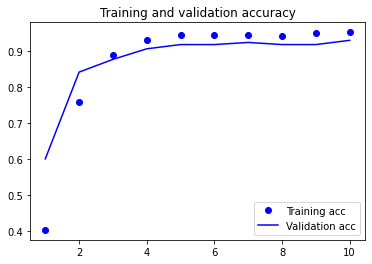

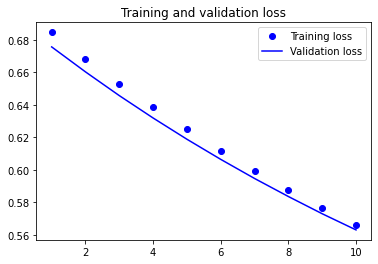

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_x)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average=None)

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9518987536430359
Val Accuracy:	 0.929411768913269
Test Accuracy:	 0.0
Precision:	 [0. 0. 0. 0.]
Recall:		 [0. 0. 0. 0.]
F1 Score:	 [0. 0. 0. 0.]
AUC:		 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
